In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats


In [2]:
%matplotlib inline

In [3]:
##function for reading out data from log file
def line_to_matrix(line):
	line = line.split('=')[1]
	line = line.split(',')
	line = map(float,line)
	line = np.array(line)
	new_out = line.reshape(-1,5)
	return new_out

In [4]:
##takes the mturk results file and makes a dictionary mapping
##the worker id to the assignment id
def get_assignment_id(assignment_file):
	rowNum=0
	worker_id_2_assignment_id = {}
	with(open(assignment_file,'rU')) as f:
		reader = csv.reader(f)
		#worker id is 15 and 14
		for row in reader:
	 		if rowNum > 0:
				worker_id_2_assignment_id[row[15]] = row[14]
			rowNum += 1
	return worker_id_2_assignment_id

In [5]:
##processed RT arrays. They are coded with a negative number for pre-target responses and -1
##missed responses. This replaces -1 with NaN, changes negative to positive, and offsets positive
##RTs by the delay to the target
def clean_RT(data,delay,thresh):
    thresh = thresh + delay_dur
    if np.ndim(data) > 0:
        data[data==-1] = np.nan
        data[data>0] = data[data>0] + delay
        data[data<0] = data[data<0] *-1
    else:
        if data == -1:
            data = np.nan
        elif data>0:
            data = data + delay
        elif data < 0:
            data = data *-1
    data = data - thresh #normalize by that subject's RT in training
    return data

In [23]:
##variables and paths
data_dir = '/Users/ianballard/Dropbox/fd/'
delay_dur = 500 ##delay before target appears

In [7]:
#when just looking at one set of data at a time use this
log_files = glob.glob(data_dir + 'data/21st_iter/*log')
# print log_files

In [8]:
def process_log_files(log_files,ip_to_id,ip_to_bonus,bad_worker,print_file_flag):
    full_data = {}
    for n,f in enumerate(log_files):
        if print_file_flag:
            print f
        bad_worker[f] = False
        subj_file = open(os.path.join(data_dir,f),'r')
        subj_file = subj_file.readlines()
        subj_file = np.array(subj_file)

        ##get mturk id
        ip_to_id[f] = subj_file[0].split(' ')[1].split('=')[1]
        if subj_file.size < 16: ##check for full data
            bad_worker[f] = True
            reason = 'incomplete'
            if print_file_flag:
                print reason + ' ' + ip_to_id[f] + ' ' + f

        if bad_worker[f] == False:

            ##process file into dictionary
            subj_dict = {}
            for n,line in enumerate(subj_file):
                if n < len(subj_file) - 1:
                    subj_dict[line.split(' ')[1].split('=')[0]] = line.split(' ')[1].split('=')[1].strip('\n')
            
            #process false alarms
            subj_dict['fa'] = subj_dict['fa'].split(',')[:-1]
            
            full_data[f] = subj_dict

            ##assess quiz
            quiz_value = int(subj_dict['quiz'])
            if quiz_value != 13:
                bad_worker[f] = True
                reason = 'quiz'
                if print_file_flag:
                    print reason + ' ' + ip_to_id[f] + ' ' + f

            ##get bonus
            ip_to_bonus[f] = float(subj_dict['bonus'])

            #get number of false alarms
    #         if len(subj_dict['fa']) > 60: #more than 20 false alarms
    #             bad_worker[f] = True

            #print experiment descriptions
    #         print subj_dict['instruct'].replace('%20', ' ')
    return ip_to_id, ip_to_bonus, bad_worker, full_data

In [9]:
#preprocesses data. Takes subj_dict, string indicating which key to analyze, and dimensions to reshaping
def preprocess_data(subj_dict,key,num_entries):
    x = map(float,subj_dict[key].split(','))
    x = np.array(x)
    x = x.reshape((x.size/num_entries, num_entries))
    return x


In [10]:
##analyze reaction time data for rt thresholding task
def process_rt(log_files, full_data, bad_worker, print_file_flag):
    accuracy = np.array([])
    rt_thresh = {}
    for n,f in enumerate(log_files):
        if print_file_flag == True:
            print f
        if bad_worker[f] == False: 
            ##preprocess
            try:
                rt = preprocess_data(full_data[f], 'rt', 3)
                rt = np.array([y for y in rt if y[0]!=-2. and y[1] < 4000 and y[0] != -1.]) #remove trials without button press, bug trials, trials with missed answers
                if rt.shape[0] < 15: #missed more than 5 responses
                    bad_worker[f] = True
                else:
                    rt_thresh[f] = rt[-1,2] #last rt threshold of training
                    ##get stats
                    accuracy = np.hstack([accuracy, 1 - np.array([x for x in rt if x[0]==0.]).shape[0]/float(rt.shape[0])])
                    if accuracy[-1] <= .3: #missed too many responses
                        bad_worker[f] = True
                    rt = np.mean(rt, axis = 0)[1]
            except:
                print f
                bad_worker[f] = True
    print np.mean(accuracy[accuracy>.2])
    print accuracy
    return accuracy, rt_thresh

In [11]:
##analyze rt data for the serial task and build dataframe
rt = []
num_trials = 25 #num trials per condition
learning_fp = np.array([])
learning_fn = np.array([])
fp_accuracy = []
fn_accuracy = [] 
r_accuracy = []
for n,f in enumerate(log_files):
    if bad_worker[f] == False: 
        print f
        ##preprocess
        ser = preprocess_data(full_data[f], 'ser', 3)
        ser = np.array([y for y in ser if y[1] < 5000]) ##remove bug trials
        
        cond = np.array( map(float, full_data[f]['cond'].split(',') ))
        rew =  np.array( map(float, full_data[f]['rew'].split(',') ))
        order = np.array( map(float, full_data[f]['trial_order'].split(',')))

        ##cond: 1: ser fp + , 2: ser fp -, 3: ser fn -, 4: ser fn +         
        ser_fp_indices = np.array([])
        ser_fn_indices = np.array([]) 
        r_indices = np.array([]) 
        count = 0
        for c in cond:
            if c == 1: #ser fp +
                ser_fp_indices = np.hstack([ser_fp_indices, count + 1])
                count = count + 3
            elif c == 2: #ser fp -
                count = count + 2
            elif c == 3: #ser fn -
                count = count + 3
            elif c == 4: #ser fn +
                ser_fn_indices = np.hstack([ser_fn_indices, count])                
                count = count + 2
            elif c==5: #always rewarded
                r_indices = np.hstack([r_indices,count])
                count = count + 2
        ##make sure have the correct number of trials (for some reason some subjects have more)
        if len(ser) == :
            ##aggregate RT stats
            fp = clean_RT(ser[ser_fp_indices.astype(int),1],delay_dur,rt_thresh[f])
            fp_accuracy.append(np.sum(ser[ser_fp_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy
            diff1 = np.mean(fp[20:24]) - np.mean(fp[15:19])

            fn = clean_RT(ser[ser_fn_indices.astype(int),1],delay_dur,rt_thresh[f])
            fn_accuracy.append(np.sum(ser[ser_fn_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy
            diff2 = np.mean(fn[20:24]) - np.mean(fn[15:19])

            r = clean_RT(ser[r_indices.astype(int),1],delay_dur,rt_thresh[f])
            r_accuracy.append(np.sum(ser[r_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy

            if np.sum(np.isnan(fp)) > 3 or np.sum(np.isnan(fn)) > 3: #missed too many responses
                bad_worker[f] = True
                print bad_worker[f]
    #         elif diff1 < 5  or diff2 < 5:
    #             None
            else:          #build dataFrame
                rt.append(pd.DataFrame(dict(condition=["fn"] * num_trials,
                                                subj = [f] * num_trials,
                                                presentation = np.arange(0,num_trials),
                                                RT = fn), dtype=np.float))
                rt.append(pd.DataFrame(dict(condition=["fp"] * num_trials,
                                        subj = [f] * num_trials,
                                        presentation = np.arange(0,num_trials),
                                        RT = fp), dtype=np.float))   
                rt.append(pd.DataFrame(dict(condition=["r"] * num_trials,
                                        subj = [f] * num_trials,
                                        presentation = np.arange(0,num_trials),
                                        RT = r), dtype=np.float))  
rt = pd.concat(rt)
print np.mean(fp_accuracy)
print np.mean(fn_accuracy)
print np.mean(r_accuracy)
a= [bad_worker[bad]==False for bad in bad_worker]
print np.sum(a)

SyntaxError: invalid syntax (<ipython-input-11-1d28e95c24ce>, line 40)

In [56]:
##Alternative code for the blocking !!SERIAL!! fd experiment!
##analyze rt data for the serial task and build dataframe
def analyze_blocking_ser(log_files,full_data, bad_worker, rt_thresh_ser, num_trials, num_block_trials, print_file_flag):  
    rt = []
    rt_block = []
#     num_trials = 10 #num trials per condition
#     num_block_trials = 13 #num trials per condition
    learning_fp = np.array([])
    learning_fn = np.array([])
    fp_accuracy = []
    fn_accuracy = [] 
    r_accuracy = []
    f_plus = {}
    g_plus = {}
    for n,f in enumerate(log_files):
        if bad_worker[f] == False: 
            if print_file_flag:
                print f
            ##preprocess
            ser = preprocess_data(full_data[f], 'ser', 3)
            ser = np.array([y for y in ser if y[1] < 5000]) ##remove bug trials

            cond = np.array( map(float, full_data[f]['cond'].split(',') ))
            rew =  np.array( map(float, full_data[f]['rew'].split(',') ))
            order = np.array( map(float, full_data[f]['trial_order'].split(',')))

            ##cond: 1: ser fp + , 2: ser fp -, 3: ser fn -, 4: ser fn +, 5: rewarded, 
            ##6: blocking AF+, 7: blocking CG+, 8: blocking HI-, 9: blocking F+, 10: blocking G+
            ser_fp_indices = np.array([])
            ser_fn_indices = np.array([]) 
            r_indices = np.array([]) 
            AF_indices = np.array([]) 
            CG_indices = np.array([]) 
            count = 0
            print cond
            for c in cond:
                if c == 1: #ser fp +
                    ser_fp_indices = np.hstack([ser_fp_indices, count + 1])
                    count = count + 3
                elif c == 2: #ser fp -
                    count = count + 2
                elif c == 3: #ser fn -
                    count = count + 3
                elif c == 4: #ser fn +
                    ser_fn_indices = np.hstack([ser_fn_indices, count])                
                    count = count + 2
    #             elif c==5: #always rewarded
    #                 r_indices = np.hstack([r_indices,count])
    #                 count = count + 2
                elif c==6: #AF+
                    AF_indices = np.hstack([AF_indices,count])
                    count = count + 2
                elif c==7: #CG+
                    CG_indices = np.hstack([CG_indices,count])
                    count = count + 2
                elif c==8: #HI-
                    count = count + 2
                elif c==9: #F+
                    AF_indices = np.hstack([AF_indices,count])
                    count = count + 2
                elif c==10: #G+
                    print 'dsfasfads'
                    CG_indices = np.hstack([CG_indices,count])
                    count = count + 2

            temp = np.array([row for row in ser if row[0]!=-2 and row[0]!=-1])
            bonus = np.sum(temp[:,0]) - len(full_data[f]['fa'])/40.0 ##fix the bonus. Code updated for next run
            ip_to_bonus[f] = bonus

#             print "recorded bonus is " + str(ip_to_bonus[f])
#             print "calculated bonus is " + str(bonus)
#             print ip_to_id[f]
            print len(ser)
            if len(ser) == 110:#156:#192 :#and bonus > 1:
                ##remove missed responses, chuck bad subjects
                fp = clean_RT(ser[ser_fp_indices.astype(int),1],delay_dur,rt_thresh_ser[f])
                fp_accuracy.append(np.sum(ser[ser_fp_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy

                fn = clean_RT(ser[ser_fn_indices.astype(int),1],delay_dur,rt_thresh_ser[f])
                fn_accuracy.append(np.sum(ser[ser_fn_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy

    #             r = clean_RT(ser[r_indices.astype(int),1],delay_dur,rt_thresh_ser[f])
    #             r_accuracy.append(np.sum(ser[r_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy

                AF = clean_RT(ser[AF_indices.astype(int),1],delay_dur,rt_thresh_ser[f])

                CG = clean_RT(ser[CG_indices.astype(int),1],delay_dur,rt_thresh_ser[f])


                if np.sum(np.isnan(fp)) > 3 or np.sum(np.isnan(fn)) > 3: #missed too many responses
                    bad_worker[f] = True
                    if print_file_flag:
                        print bad_worker[f]
#                 elif fp_accuracy[-1]<.25 or fn_accuracy[-1] < .25 or len(full_data[f]['fa'])>20:
#                     None

                else:          #build dataFrame
        
                    print len(fp)
                    print len(CG)
                    rt.append(pd.DataFrame(dict(condition=["D_ser"] * num_trials,
                                                    subj = [f] * num_trials,
                                                    presentation = np.arange(0,num_trials),
                                                    RT = fn), dtype=np.float))
                    rt.append(pd.DataFrame(dict(condition=["AB_ser"] * num_trials,
                                            subj = [f] * num_trials,
                                            presentation = np.arange(0,num_trials),
                                            RT = fp), dtype=np.float))   
    #                 rt.append(pd.DataFrame(dict(condition=["r"] * num_trials,
    #                                         subj = [f] * num_trials,
    #                                         presentation = np.arange(0,num_trials),
    #                                         RT = r), dtype=np.float))  
                    rt_block.append(pd.DataFrame(dict(condition=["AF_ser"] * num_block_trials,
                                            subj = [f] * num_block_trials,
                                            presentation = np.arange(0,num_block_trials),
                                            RT = AF), dtype=np.float)) 
                    rt_block.append(pd.DataFrame(dict(condition=["CG_ser"] * num_block_trials,
                            subj = [f] * num_block_trials,
                            presentation = np.arange(0,num_block_trials),
                            RT = CG), dtype=np.float))
        
    
    print "num ser subjects is " + str(len(rt)/2.0)               
    print "ser fp accuracy is " + str(np.mean(fp_accuracy))
    print "ser fn accuracy is " + str(np.mean(fn_accuracy))
    rt = pd.concat(rt)
    rt_block = pd.concat(rt_block)    
    return rt, rt_block

In [57]:
##code for the blocking !!SIMULTANEOUS!! fd experiment!
##analyze rt data for the serial task and build dataframe
def analyze_blocking_sim(log_files,full_data, bad_worker, rt_thresh_sim, num_trials, num_block_trials, print_file_flag):  
    rt = []
    rt_block = []
    learning_fp = np.array([])
    learning_fn = np.array([])
    fp_accuracy = []
    fn_accuracy = [] 
    r_accuracy = []
    f_plus = {}
    g_plus = {}
    for n,f in enumerate(log_files):
        if bad_worker[f] == False: 
            if print_file_flag:
                print f
            ##preprocess
            ser = preprocess_data(full_data[f], 'ser', 3)
            ser = np.array([y for y in ser if y[1] < 5000]) ##remove bug trials

            cond = np.array( map(float, full_data[f]['cond'].split(',') ))
            rew =  np.array( map(float, full_data[f]['rew'].split(',') ))
            order = np.array( map(float, full_data[f]['trial_order'].split(',')))
            print cond
            ##cond: 1: ser fp + , 2: ser fp -, 3: ser fn -, 4: ser fn +, 5: rewarded, 
            ##6: blocking AF+, 7: blocking CG+, 8: blocking HI-, 9: blocking F+, 10: blocking G+
            ser_fp_indices = np.array([])
            ser_fn_indices = np.array([]) 
            r_indices = np.array([]) 
            AF_indices = np.array([]) 
            CG_indices = np.array([]) 
            count = 0
            for c in cond:
                if c == 1: #sim AB+
                    ser_fp_indices = np.hstack([ser_fp_indices, count])
                    count = count + 2
                elif c == 2: #ser B -
                    count = count + 2
                elif c == 3: #ser CD -
                    count = count + 2
                elif c == 4: #ser C +
                    ser_fn_indices = np.hstack([ser_fn_indices, count])                
                    count = count + 2
    #             elif c==5: #E+ always rewarded
    #                 r_indices = np.hstack([r_indices,count])
    #                 count = count + 2
                elif c==6: #AF+
                    AF_indices = np.hstack([AF_indices,count])
                    count = count + 2
                elif c==7: #CG+
                    CG_indices = np.hstack([CG_indices,count])
                    count = count + 2
                elif c==8: #HI-
                    count = count + 2
                elif c==9: #F+
    #                 f_idx = count  
                    AF_indices = np.hstack([AF_indices,count])
    #                 f_idx = np.hstack([f_idx,count])            
                    count = count + 2
                elif c==10: #G+
                    CG_indices = np.hstack([CG_indices,count])
    #                 g_idx = count 
    #                 g_idx = np.hstack([g_idx,count])            
                    count = count + 2


            temp = np.array([row for row in ser if row[0]!=-2 and row[0]!=-1])
            bonus = np.sum(temp[:,0]) - len(full_data[f]['fa'])/40.0 ##fix the bonus. Code updated for next run
            ip_to_bonus[f] = bonus

            print len(ser)
            if len(ser) == 140:#192 :#and bonus > 1:##140: ##check to make sure everyone has the same number of responses

                    ##remove missed responses, chuck bad subjects
                    fp = clean_RT(ser[ser_fp_indices.astype(int),1],delay_dur,rt_thresh_sim[f])
                    fp_accuracy.append(np.sum(ser[ser_fp_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy

                    fn = clean_RT(ser[ser_fn_indices.astype(int),1],delay_dur,rt_thresh_sim[f])
                    fn_accuracy.append(np.sum(ser[ser_fn_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy

        #             r = clean_RT(ser[r_indices.astype(int),1],delay_dur,rt_thresh_sim[f])
        #             r_accuracy.append(np.sum(ser[r_indices.astype(int),0] == .05)*1.0 / num_trials) #accuracy

                    AF = clean_RT(ser[AF_indices.astype(int),1],delay_dur,rt_thresh_sim[f])

                    CG = clean_RT(ser[CG_indices.astype(int),1],delay_dur,rt_thresh_sim[f])

                    mean_blocking_RT = np.nanmean(np.hstack([CG[1:],AF[1:]])) ##mean RT for end of session

        #             g_plus[f] = clean_RT(np.array(ser[g_idx,1]),delay_dur,rt_thresh[f])
        #             f_plus[f] = clean_RT(np.array(ser[f_idx,1]),delay_dur,rt_thresh[f])

        #             AF = np.append(AF,f_plus[f])
        #             CG = np.append(CG,g_plus[f])

                    if np.sum(np.isnan(fp)) > 3 or np.sum(np.isnan(fn)) > 3: #missed too many responses
                        bad_worker[f] = True
                        if print_file_flag:
                            print bad_worker[f]
#                     elif fp_accuracy[-1]<.25 or fn_accuracy[-1] < .25 or len(full_data[f]['fa'])>20:
#                         None
                    else:          #build dataFrame
                        rt.append(pd.DataFrame(dict(condition=["D_sim"] * num_trials,
                                                        subj = [f] * num_trials,
                                                        presentation = np.arange(0,num_trials),
                                                        RT = fn), dtype=np.float))
                        rt.append(pd.DataFrame(dict(condition=["AB_sim"] * num_trials,
                                                subj = [f] * num_trials,
                                                presentation = np.arange(0,num_trials),
                                                RT = fp), dtype=np.float))   
        #                 rt.append(pd.DataFrame(dict(condition=["r"] * num_trials,
        #                                         subj = [f] * num_trials,
        #                                         presentation = np.arange(0,num_trials),
        #                                         RT = r), dtype=np.float))  
                        rt_block.append(pd.DataFrame(dict(condition=["AF_sim"] * num_block_trials,
                                                subj = [f] * num_block_trials,
                                                presentation = np.arange(0,num_block_trials),
                                                RT = AF), dtype=np.float)) 
                        rt_block.append(pd.DataFrame(dict(condition=["CG_sim"] * num_block_trials,
                                subj = [f] * num_block_trials,
                                presentation = np.arange(0,num_block_trials),
                                RT = CG), dtype=np.float)) 

    print "num sim subjects is " + str(len(rt)/2.0)               
    print "sim fp accuracy is " + str(np.mean(fp_accuracy))
    print "sim fn accuracy is " + str(np.mean(fn_accuracy))
    rt = pd.concat(rt)
    rt_block = pd.concat(rt_block)

    # print np.mean(r_accuracy)
#     a= [bad_worker[bad]==False for bad in bad_worker]
#     print np.sum(a)
    
    return rt, rt_block

In [58]:
##MAIN ANALYSIS CODE
##process data for both sim and ser experiments
log_files_sim = glob.glob(data_dir + 'data/24th_iter/*log')
log_files_ser = glob.glob(data_dir + 'data/24th_iter/*log')
print len(log_files_sim)
print len(log_files_ser)

ip_to_bonus = {}
ip_to_id = {}
bad_worker = {}
ip_to_bonus = {}
##process log files
#ip_to_id, ip_to_bonus, bad_worker, full_data_sim = process_log_files(log_files_sim,ip_to_id,ip_to_bonus,bad_worker,False)
ip_to_id, ip_to_bonus, bad_worker, full_data_ser = process_log_files(log_files_ser,ip_to_id,ip_to_bonus,bad_worker,False)

##analyze RT
#accuracy_sim, rt_thresh_sim = process_rt(log_files_sim, full_data_sim, bad_worker, False)
accuracy_ser, rt_thresh_ser = process_rt(log_files_ser, full_data_ser, bad_worker, False)

##analyze main task data
#rt_sim, rt_block_sim = analyze_blocking_sim(log_files_sim,full_data_sim, bad_worker, rt_thresh_sim, 10, 13, False)  
rt_ser, rt_block_ser = analyze_blocking_ser(log_files_ser,full_data_ser, bad_worker, rt_thresh_ser, 11, 11, False)

28
28
0.547619047619
[ 0.6         0.6         0.6         0.46666667  0.6         0.53333333
  0.53333333  0.46666667  0.6         0.6         0.4         0.6         0.6
  0.46666667]
[ 4.  6.  4.  1.  1.  4.  4.  3.  6.  6.  6.  6.  3.  6.  3.  1.  4.  3.
  6.  4.  6.  4.  3.  1.  3.  4.  3.  6.  3.  1.  1.  1.  3.  1.  1.  1.
  4.  4.  3.  6.  6.  4.  3.  1.]
110
11
0


ValueError: arrays must all be same length

In [1040]:
# #plot last trial blocking data
# blocking_data = pd.DataFrame(dict(gplus_serial=g_plus, fplus_serial=f_plus), index = g_plus.keys())
# blocking_data.dropna()
# sns.violinplot(blocking_data.dropna(), color="pastel");

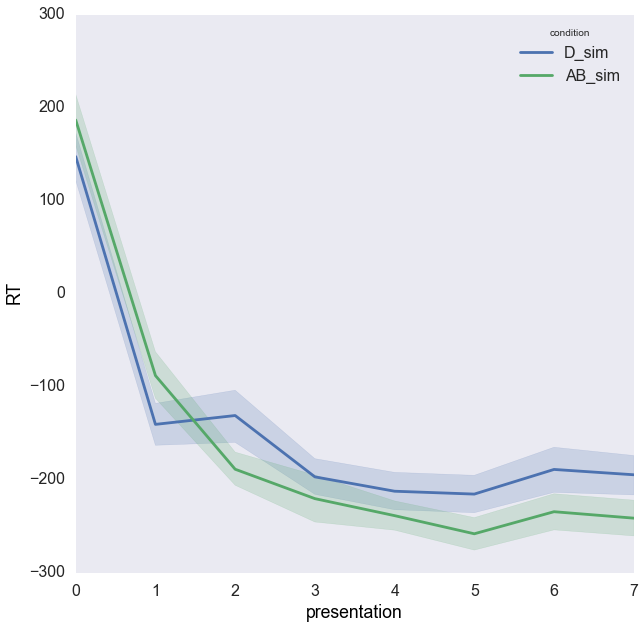

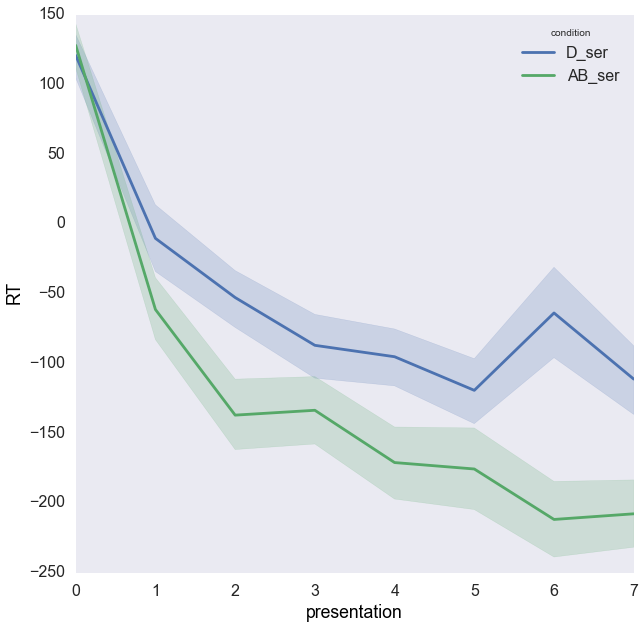

In [1041]:
#do some basic analysis on time series data
#         learning_fp = np.hstack([learning_fp , np.mean(ser_fp_rt[f][0:9]) - np.mean(ser_fp_rt[f][10:19])])
#         learning_fn = np.hstack([learning_fn,np.mean(ser_fn_rt[f][0:9]) - np.mean(ser_fn_rt[f][10:19])])
# total_rt = [rt_ser,rt_sim]
# total_rt = pd.concat(total_rt)
f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_sim, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_ser, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

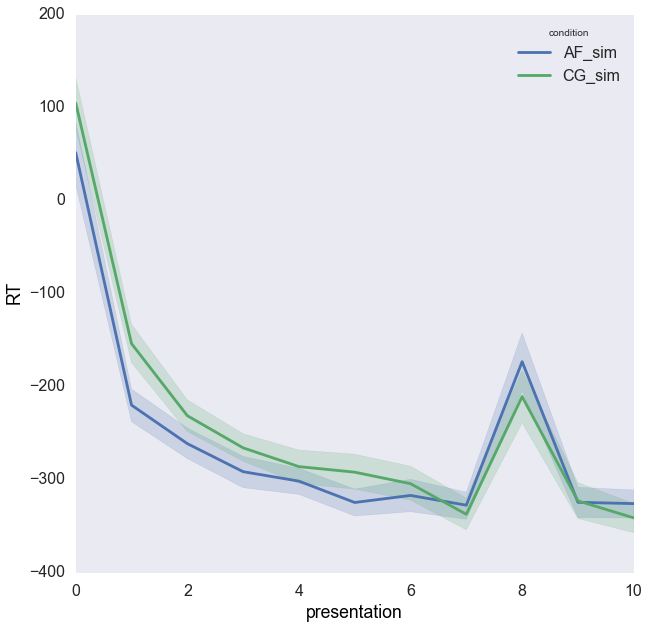

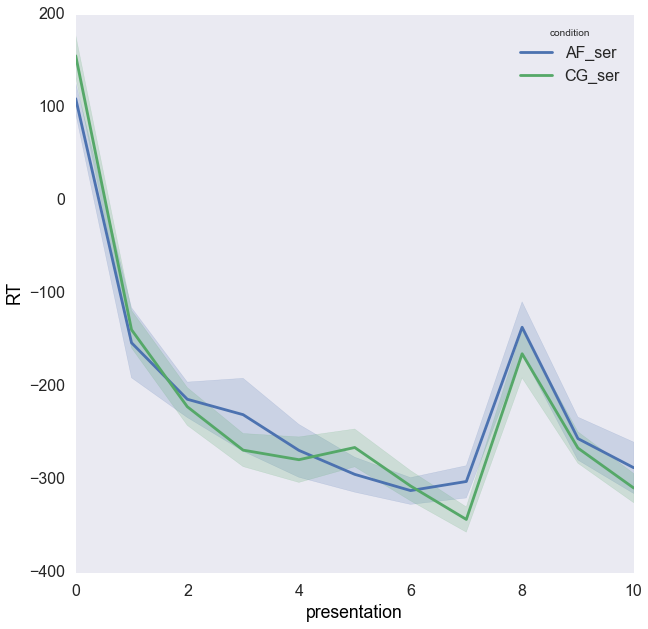

In [1035]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_block_sim, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')


f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_block_ser, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

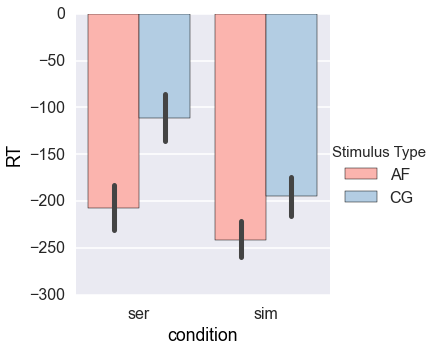

In [1047]:
##analyze serial data for reversal condition
##want interaction between ser/sim and AF/CG

last_block1 = np.array(rt_ser[(rt_ser['condition'] == 'AF_ser') & (rt_ser['presentation'] ==7)].iloc[:,0])
last_block2 = np.array(rt_ser[(rt_ser['condition'] == 'AF_ser') & (rt_ser['presentation'] ==6)].iloc[:,0])
last_block3 = np.array(rt_ser[(rt_ser['condition'] == 'AF_ser') & (rt_ser['presentation'] ==5)].iloc[:,0])
last_block4 = np.array(rt_ser[(rt_ser['condition'] == 'AF_ser') & (rt_ser['presentation'] ==4)].iloc[:,0])
switch = np.array(rt_ser[(rt_ser['condition'] == 'AB_ser') & (rt_ser['presentation'] == 7)].iloc[:,0])
rt_diff_AF_ser = switch
# rt_diff_AF_ser = switch - last_block1;

last_block1 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 7)].iloc[:,0])
last_block2 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 6)].iloc[:,0])
last_block3 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 5)].iloc[:,0])
last_block4 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 4)].iloc[:,0])
switch = np.array(rt_ser[(rt_ser['condition'] == 'D_ser') & (rt_ser['presentation'] == 7)].iloc[:,0])
rt_diff_CG_ser = switch 
# rt_diff_CG_ser = switch - last_block1;

last_block1 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 7)].iloc[:,0])
last_block2 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 6)].iloc[:,0])
last_block3 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 5)].iloc[:,0])
last_block4 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 4)].iloc[:,0])
switch = np.array(rt_sim[(rt_sim['condition'] == 'AB_sim') & (rt_sim['presentation'] == 7)].iloc[:,0])
rt_diff_AF_sim = switch 
# rt_diff_AF_sim = switch - last_block1;

last_block1 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 7)].iloc[:,0])
last_block2 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 6)].iloc[:,0])
last_block3 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 5)].iloc[:,0])
last_block4 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 4)].iloc[:,0])
switch = np.array(rt_sim[(rt_sim['condition'] == 'D_sim') & (rt_sim['presentation'] == 7)].iloc[:,0])
rt_diff_CG_sim = switch 
# rt_diff_CG_sim = switch - last_block1;

num_subs_ser = len(rt_diff_AF_ser)
num_subs_sim = len(rt_diff_AF_sim)
RT = np.hstack((rt_diff_AF_ser.ravel(), rt_diff_CG_ser.ravel(), rt_diff_AF_sim.ravel() ,rt_diff_CG_sim.ravel()))
stim_type = ['AF']*num_subs_ser + ['CG']*num_subs_ser + ['AF'] *num_subs_sim + ['CG'] * num_subs_sim
cond = ['ser']*num_subs_ser + ['ser']*num_subs_ser + ['sim'] *num_subs_sim + ['sim'] * num_subs_sim

d = {'RT': RT , 'condition': cond, 'Stimulus Type': stim_type}
d = DataFrame(d)

#plot
sns.factorplot('condition','RT','Stimulus Type', data=d,kind='bar',palette="Pastel1",ci=68);

In [ ]:
##analyze serial data for reversal condition
##want interaction between ser/sim and AF/CG

last_block1 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'AF_ser') & (rt_block_ser['presentation'] ==7)].iloc[:,0])
last_block2 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'AF_ser') & (rt_block_ser['presentation'] ==6)].iloc[:,0])
last_block3 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'AF_ser') & (rt_block_ser['presentation'] ==5)].iloc[:,0])
last_block4 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'AF_ser') & (rt_block_ser['presentation'] ==4)].iloc[:,0])
switch = np.array(rt_block_ser[(rt_block_ser['condition'] == 'AF_ser') & (rt_block_ser['presentation'] == 8)].iloc[:,0])
rt_diff_AF_ser = switch - (last_block1 + last_block2 + last_block3 + last_block4)/4.0
# rt_diff_AF_ser = switch - last_block1;

last_block1 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 7)].iloc[:,0])
last_block2 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 6)].iloc[:,0])
last_block3 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 5)].iloc[:,0])
last_block4 = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 4)].iloc[:,0])
switch = np.array(rt_block_ser[(rt_block_ser['condition'] == 'CG_ser') & (rt_block_ser['presentation'] == 8)].iloc[:,0])
rt_diff_CG_ser = switch - (last_block1 + last_block2 + last_block3 + last_block4)/4.0
# rt_diff_CG_ser = switch - last_block1;

last_block1 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 7)].iloc[:,0])
last_block2 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 6)].iloc[:,0])
last_block3 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 5)].iloc[:,0])
last_block4 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 4)].iloc[:,0])
switch = np.array(rt_block_sim[(rt_block_sim['condition'] == 'AF_sim') & (rt_block_sim['presentation'] == 8)].iloc[:,0])
rt_diff_AF_sim = switch - (last_block1 + last_block2 + last_block3 + last_block4)/4.0
# rt_diff_AF_sim = switch - last_block1;

last_block1 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 7)].iloc[:,0])
last_block2 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 6)].iloc[:,0])
last_block3 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 5)].iloc[:,0])
last_block4 = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 4)].iloc[:,0])
switch = np.array(rt_block_sim[(rt_block_sim['condition'] == 'CG_sim') & (rt_block_sim['presentation'] == 8)].iloc[:,0])
rt_diff_CG_sim = switch - (last_block1 + last_block2 + last_block3 + last_block4)/4.0
# rt_diff_CG_sim = switch - last_block1;

num_subs_ser = len(rt_diff_AF_ser)
num_subs_sim = len(rt_diff_AF_sim)
RT = np.hstack((rt_diff_AF_ser.ravel(), rt_diff_CG_ser.ravel(), rt_diff_AF_sim.ravel() ,rt_diff_CG_sim.ravel()))
stim_type = ['AF']*num_subs_ser + ['CG']*num_subs_ser + ['AF'] *num_subs_sim + ['CG'] * num_subs_sim
cond = ['ser']*num_subs_ser + ['ser']*num_subs_ser + ['sim'] *num_subs_sim + ['sim'] * num_subs_sim

d = {'RT': RT , 'condition': cond, 'Stimulus Type': stim_type}
d = DataFrame(d)

#plot
sns.factorplot('condition','RT','Stimulus Type', data=d,kind='bar',palette="Pastel1",ci=68);

In [1049]:
## compute anova
formula = 'RT ~ C(cond) + C(stim_type) + C(cond):C(stim_type)'
lm = ols(formula, d).fit()
print(anova_lm(lm))

sim_diff = rt_diff_AF_sim - rt_diff_CG_sim
ser_diff = rt_diff_AF_ser - rt_diff_CG_ser
sim_diff = sim_diff[~np.isnan(sim_diff)]
ser_diff = ser_diff[~np.isnan(ser_diff)]

t,p = scipy.stats.ttest_ind(sim_diff,ser_diff)
print t, p

t,p = scipy.stats.ttest_1samp(sim_diff,0)
print t, p


                       df           sum_sq        mean_sq         F    PR(>F)
C(cond)                 1    279936.310427  279936.310427  6.784110  0.009625
C(stim_type)            1    401521.793029  401521.793029  9.730671  0.001977
C(cond):C(stim_type)    1     50479.516861   50479.516861  1.223345  0.269533
Residual              321  13245591.690451   41263.525515       NaN       NaN
1.7945035433 0.0746568682389
-2.11597677171 0.0373431345797


In [1048]:
## compute anova
formula = 'RT ~ C(cond) + C(stim_type) + C(cond):C(stim_type)'
lm = ols(formula, d).fit()
print(anova_lm(lm))

sim_diff = rt_diff_AF_sim - rt_diff_CG_sim
ser_diff = rt_diff_AF_ser - rt_diff_CG_ser
sim_diff = sim_diff[~np.isnan(sim_diff)]
ser_diff = ser_diff[~np.isnan(ser_diff)]

t,p = scipy.stats.ttest_ind(sim_diff,ser_diff)
print t, p

                       df           sum_sq        mean_sq         F    PR(>F)
C(cond)                 1    279936.310427  279936.310427  6.784110  0.009625
C(stim_type)            1    401521.793029  401521.793029  9.730671  0.001977
C(cond):C(stim_type)    1     50479.516861   50479.516861  1.223345  0.269533
Residual              321  13245591.690451   41263.525515       NaN       NaN
1.7945035433 0.0746568682389


In [1214]:
##payment  
assignment_file = os.path.join(data_dir,'results/Batch_1829547_batch_results.csv')
payment_file = os.path.join(data_dir,'results/payment22.txt')
worker_id_2_assignment_id = get_assignment_id(assignment_file)

iter_list = set(ip_to_id.keys())
completed = []

for n,f in enumerate(iter_list):
    if bad_worker[f] == False:
        sub_id = ip_to_id[f].strip('\n')
        try:
            assignment_id = worker_id_2_assignment_id[ip_to_id[f].strip('\n')]

        except:
             print ip_to_id[f] + ' is not in results file' + f
        
        else:
            if sub_id not in completed: #output results
                completed = completed + [sub_id]
                out_str = [assignment_id ,sub_id , str(ip_to_bonus[f] + .5)]
                if ip_to_bonus[f] > 0:
                    pay = open(payment_file,'a')
                    pay.write('\t'.join(out_str))
                    pay.write('\n')


In [384]:
a=[round(1 + random.uniform(-.5,.5),2) for i in range(0,1000)]


[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[2, 10, 3, 10, 4, 10, 1, 10, 1, 10, 2, 10, 4, 10, 4, 10, 1, 10, 3, 10, 3, 10, 3, 10, 3, 10, 3, 10, 1, 10, 2, 10, 1, 10, 4, 10, 3, 10, 1, 10, 1, 10, 2, 10, 4, 10, 3, 10, 2, 10, 2, 10, 1, 10, 3, 10, 2, 10, 4, 10, 3, 10, 4, 10, 1, 10, 1, 10, 4, 10, 2, 10, 4, 10, 4, 10, 2, 10, 2, 10, 1, 10, 2, 10, 3, 10, 4, 10]
[2, 3, 4, 1, 1, 2, 4, 4, 1, 3, 3, 3, 3, 3, 1, 2, 1, 4, 3, 1, 1, 2, 4, 3, 2, 2, 1, 3, 2, 4, 3, 4, 1, 1, 4, 2, 4, 4, 2, 2, 1, 2, 3, 4]


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.]
[ 0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
[4, 5, 10, 4, 5, 10, 4, 5, 10, 3, 10, 6, 10, 6, 10, 4, 5, 10, 3, 10, 4, 5, 10, 1, 2, 10, 3, 10, 1, 2, 10, 1, 2, 10, 3, 10, 1, 2, 10, 1, 2, 10, 6, 10, 3, 10, 1, 2, 10, 1, 2, 10, 4, 5, 10, 1, 2, 10, 4, 5, 10, 1, 2, 10, 3, 10, 6, 10, 3, 10, 6, 10, 6, 10, 4, 5, 10, 6, 10, 6, 10, 6, 10, 4, 5, 10, 4, 5, 10, 3, 10, 3, 10, 6, 10, 1, 2, 10, 3, 10, 6, 10, 3, 10, 1, 2, 10, 4, 5, 10]
[4, 4, 4, 3, 6, 6,

In [15]:
import lyman
print lyman.default_experiment_parameters()

{'cluster_zthresh': 2.3, 'flame_mode': 'flame1', 'temporal_interp': False, 'hrf_params': {}, 'whole_brain_template': '', 'regressor_names': None, 'motion_threshold': 1, 'hrf_model': 'GammaDifferenceHRF', 'slice_order': 'up', 'confound_pca': False, 'surf_smooth': 5, 'smooth_fwhm': 6, 'condition_names': None, 'TR': 2, 'sampling_method': 'average', 'surf_corr_sign': 'pos', 'regressor_file': None, 'temporal_deriv': False, 'design_name': None, 'frames_to_toss': 0, 'sampling_range': (0, 1, 0.1), 'grf_pthresh': 0.05, 'contrasts': [], 'interleaved': True, 'source_template': '', 'intensity_threshold': 4.5, 'peak_distance': 30, 'coreg_init': 'fsl', 'spike_threshold': None, 'surf_name': 'inflated', 'memory_request': 5, 'hpf_cutoff': 128, 'sampling_units': 'frac', 'n_runs': 0}
